In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, RandomPerspective, Normalize, Resize, RandomRotation
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os 

torch.manual_seed(3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4

composed = Compose([
                    Resize(32),
                    ToTensor(),
                    Normalize((0.1307,), (0.3081,)),
                    RandomRotation(10),
                    ])
train_data = torchvision.datasets.MNIST(root='./data',
                                                  train = True,
                                                  transform = composed,
                                                  download = True)
validation_data = torchvision.datasets.MNIST(root='./data',
                                                  train = False,
                                                  transform = composed,
                                                  download = True)

# create subset of dataset

# idx1 = list(range(3000))
# idx2 = list(range(3000,3800))
# train_set = torch.utils.data.Subset(train_data, idx1)
# validation_set = torch.utils.data.Subset(train_data, idx2)
# train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = False)
# validation_loader = DataLoader(validation_set, batch_size = batch_size, shuffle = False)


train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = True)
print(len(train_loader))
X, y = next(iter(train_loader))
print(X.shape, y.shape)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_trainer_{}'.format(timestamp))
img_grid = torchvision.utils.make_grid(X)
writer.add_image('mnist_images', img_grid)

100%|██████████| 9912422/9912422 [00:00<00:00, 277313762.69it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29028443.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 141305015.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16725661.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

15000
torch.Size([4, 1, 32, 32]) torch.Size([4])


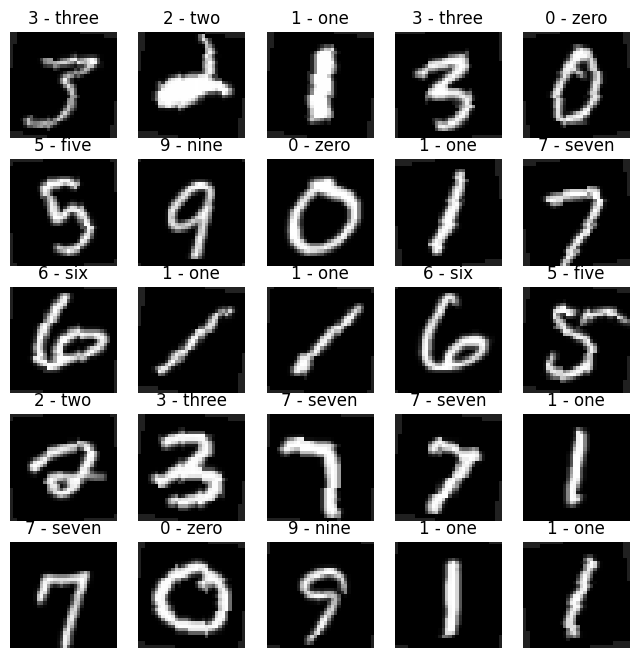

In [2]:
import matplotlib.pyplot as plt

torch.manual_seed(3)

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    label_name = train_data.classes[label]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(label_name)
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [3]:
import torch.nn as nn

torch.manual_seed(3)

class LeNet5(nn.Module):
  # size of input (batch_size, channels, 32, 32) is fixed

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 6, 5),
        nn.Tanh(),
        nn.AvgPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, 5),
        nn.Tanh(),
        nn.AvgPool2d(2)
    )
    
    # shape of flattened array below is fixed but
    # can be calculated using a formula
    self.lin1 = nn.Linear(400, 120) 
    self.lin2 = nn.Linear(120, 84)
    self.lin3 = nn.Linear(84, 10)
    self.tanh = nn.Tanh()

  def forward(self, x):
    N = x.shape[0]

    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(N, -1)
    x = self.tanh(self.lin1(x))
    x = self.tanh(self.lin2(x))
    x = self.lin3(x)

    return x

model = LeNet5().to(device)
writer.add_graph(model, X.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) 
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience = 2, verbose = True)

In [ ]:
torch.manual_seed(3)

def train_one_epoch(epoch_index, tb_writer, num_epochs):
    running_loss = 0.
    last_loss = 0.
    n_total_steps = len(train_loader)

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # average loss per previous 1000 batches   
            print (f'Epoch [{epoch_index+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {last_loss:.6f}')
            
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x) 
            running_loss = 0.

    return last_loss # average loss per last 1000 batches

In [ ]:
path = "models"
isExist = os.path.exists(path)
if not isExist:
   os.makedirs(path)
   print("The new directory is created!")

The new directory is created!


In [ ]:
torch.manual_seed(3)


EPOCHS = 20
best_vloss = 1_000_000.

for epoch in range(EPOCHS):

    print('EPOCH {}:'.format(epoch + 1))
    # ensure proper behaviour of Dropout and BatchNorm, which behave differently during training and evaluation
    model.train(True) 
    # avg loss per last 1000 batches
    avg_loss = train_one_epoch(epoch, writer, EPOCHS)
    running_vloss = 0.0

    # ensure proper behaviour of Dropout and BatchNorm
    model.eval() 
    with torch.no_grad():
        correct = 0
        for i, vdata in enumerate(validation_loader): 
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)

            _, predicted = torch.max(voutputs.data, 1)
            correct += (predicted == vlabels).sum().item()

            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1) # average loss on whole validation set 
    vaccuracy = correct/(len(validation_loader) * batch_size) * 100
    print('LOSS train {} valid {} vaccuracy {}%'.format(avg_loss, avg_vloss, vaccuracy))
    writer.add_scalar('vaccuracy', vaccuracy, epoch + 1)

    # log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)
    writer.flush()

    # track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/model_{}_{}'.format(timestamp, epoch)
        torch.save(model.state_dict(), model_path)
    scheduler.step(avg_vloss)
writer.close()

EPOCH 1:
Epoch [1/20], Step [1000/15000], Loss: 1.185420
Epoch [1/20], Step [2000/15000], Loss: 0.534017
Epoch [1/20], Step [3000/15000], Loss: 0.419836
Epoch [1/20], Step [4000/15000], Loss: 0.369497
Epoch [1/20], Step [5000/15000], Loss: 0.335265
Epoch [1/20], Step [6000/15000], Loss: 0.315216
Epoch [1/20], Step [7000/15000], Loss: 0.284637
Epoch [1/20], Step [8000/15000], Loss: 0.243911
Epoch [1/20], Step [9000/15000], Loss: 0.239330
Epoch [1/20], Step [10000/15000], Loss: 0.219222
Epoch [1/20], Step [11000/15000], Loss: 0.200003
Epoch [1/20], Step [12000/15000], Loss: 0.189904
Epoch [1/20], Step [13000/15000], Loss: 0.168604
Epoch [1/20], Step [14000/15000], Loss: 0.153746
Epoch [1/20], Step [15000/15000], Loss: 0.160232
LOSS train 0.1602315187440254 valid 0.14792966842651367 vaccuracy 95.35%
EPOCH 2:
Epoch [2/20], Step [1000/15000], Loss: 0.137140
Epoch [2/20], Step [2000/15000], Loss: 0.141910
Epoch [2/20], Step [3000/15000], Loss: 0.139640
Epoch [2/20], Step [4000/15000], Loss: 

In [ ]:
# load the model

# loaded_model = LeNet5()
# loaded_model.load_state_dict(torch.load("models/model_20230604_125620_16"))
# loaded_model.eval()
# loaded_model.to(device)